In [13]:
%matplotlib inline
import pandas as pd

## Download data 

In [78]:
month_ends = pd.date_range(start='1995-12-31', end=pd.datetime.today(), freq='M')
month_starts = month_ends + pd.Timedelta('1d')
month_ends = month_ends[1:]
month_starts = month_starts[:-1]

tides = pd.DataFrame()
for start, end in zip(month_starts, month_ends):
    start_str = f'{start.year}{start.month:02d}{start.day:02d}'
    end_str = f'{end.year}{end.month:02d}{end.day:02d}'
    
    print(f'downloading from {start_str} to {end_str}')
    
    df = pd.read_csv(f'https://tidesandcurrents.noaa.gov/api/datagetter?product=water_level'+
                f'&application=NOS.COOPS.TAC.WL&begin_date={start_str}&end_date={end_str}&'+
                f'datum=MLLW&station=9415020&time_zone=lst&units=metric&format=csv', index_col=0)
    
    tides = pd.concat([tides, df])
    
tides.to_csv(f'point_reyes_tides_{start_str}_{end_str}.csv.gz', compression='gzip')

downloading from 19960101 to 19960131
downloading from 19960201 to 19960229
downloading from 19960301 to 19960331
downloading from 19960401 to 19960430
downloading from 19960501 to 19960531
downloading from 19960601 to 19960630
downloading from 19960701 to 19960731
downloading from 19960801 to 19960831
downloading from 19960901 to 19960930
downloading from 19961001 to 19961031
downloading from 19961101 to 19961130
downloading from 19961201 to 19961231
downloading from 19970101 to 19970131
downloading from 19970201 to 19970228
downloading from 19970301 to 19970331
downloading from 19970401 to 19970430
downloading from 19970501 to 19970531
downloading from 19970601 to 19970630
downloading from 19970701 to 19970731
downloading from 19970801 to 19970831
downloading from 19970901 to 19970930
downloading from 19971001 to 19971031
downloading from 19971101 to 19971130
downloading from 19971201 to 19971231
downloading from 19980101 to 19980131
downloading from 19980201 to 19980228
downloading 

downloading from 20140101 to 20140131
downloading from 20140201 to 20140228
downloading from 20140301 to 20140331
downloading from 20140401 to 20140430
downloading from 20140501 to 20140531
downloading from 20140601 to 20140630
downloading from 20140701 to 20140731
downloading from 20140801 to 20140831
downloading from 20140901 to 20140930
downloading from 20141001 to 20141031
downloading from 20141101 to 20141130
downloading from 20141201 to 20141231
downloading from 20150101 to 20150131
downloading from 20150201 to 20150228
downloading from 20150301 to 20150331
downloading from 20150401 to 20150430
downloading from 20150501 to 20150531
downloading from 20150601 to 20150630
downloading from 20150701 to 20150731
downloading from 20150801 to 20150831
downloading from 20150901 to 20150930
downloading from 20151001 to 20151031
downloading from 20151101 to 20151130
downloading from 20151201 to 20151231
downloading from 20160101 to 20160131
downloading from 20160201 to 20160229
downloading 

In [81]:
tides.to_csv(f'point_reyes_tides_{start_str}_{end_str}.csv.gz', compression='gzip')

In [86]:
tides

,Water Level,Sigma,O,F,R,L,Quality
Date Time,,,,,,,
1996-01-01 00:00,0.667,0.097,0,0,0,0,v
1996-01-01 00:06,0.743,0.127,0,0,0,0,v
1996-01-01 00:12,0.699,0.156,0,0,1,0,v
1996-01-01 00:18,0.676,0.102,0,0,1,0,v
1996-01-01 00:24,0.560,0.105,0,0,0,0,v
1996-01-01 00:30,0.690,0.133,0,0,0,0,v
1996-01-01 00:36,0.700,0.084,0,0,0,0,v
1996-01-01 00:42,0.689,0.151,0,0,0,0,v
1996-01-01 00:48,0.658,0.077,0,0,0,0,v


In [22]:
tides = pd.read_csv('https://tidesandcurrents.noaa.gov/api/datagetter?product=water_level'+
                    '&application=NOS.COOPS.TAC.WL&begin_date=19960101&end_date=19960131&'+
                    'datum=MLLW&station=9415020&time_zone=lst&units=metric&format=csv', index_col=0)

In [23]:
new_df = pd.read_csv('https://tidesandcurrents.noaa.gov/api/datagetter?product=water_level'+
                    '&application=NOS.COOPS.TAC.WL&begin_date=19960201&end_date=19960229&'+
                    'datum=MLLW&station=9415020&time_zone=lst&units=metric&format=csv', index_col=0)

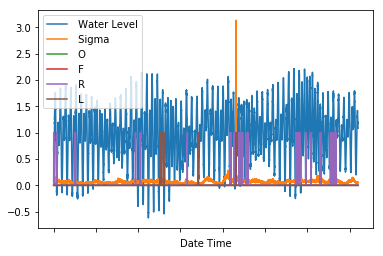

In [25]:
pd.concat([tides,new_df]).plot()

In [63]:
month_starts.year

Int64Index([1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2018],
           dtype='int64', length=265)

In [62]:
dir(month_starts[0])

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_date_repr',
 '_get_field',
 '_get_start_end_field',
 '_has_time_component',
 '_repr_base',
 '_round',
 '_short_repr',
 '_time_repr',
 'asm8',
 'astimezone',
 'ceil',
 'combine',
 'ctime',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'floor',
 'fold',
 'freq',
 'freqstr',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'm

In [58]:
# tides

## Experiments 

In [27]:
import scipy.sparse as sp
import numpy as np

In [32]:
a = np.arange(1000.)
b = np.arange(1000.)

In [33]:
%timeit a*b

960 ns ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [38]:
%timeit sp.diags(a)@b

65.3 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%timeit c = np.array(a)

593 ns ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [41]:
%timeit c = np.array(a, copy=False)

166 ns ± 4.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [42]:
d = np.array([1,2])

In [43]:
%timeit e = np.array(d)

408 ns ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [44]:
%timeit e = np.array(d, copy=False)

155 ns ± 2.16 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [45]:
%timeit e = d

22.2 ns ± 0.931 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
